<a href="https://colab.research.google.com/github/MutianWang/novel-cell/blob/main/human/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel Cells Generation

In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Brain Cell/data/'

## Preprocessing

In [ ]:
meta = pd.read_csv(path+'meta.csv', header=0)
cols_glut = meta[meta['class']=='Glutamatergic']['sample_name']
cols_non = meta[meta['class']=='Non-neuronal']['sample_name']
cols_gaba = meta[meta['class']=='GABAergic']['sample_name']

In [ ]:
def normalize(df):
    # counts per million
    df = df.div(df.sum(axis=1), axis=0) * 10**6
    df = df.fillna(0)
    return df

In [ ]:
def read_expression(file1, file2, usecols):
    # point-wise addition of exon and intron tables
    reader1 = pd.read_csv(file1, header=0, usecols=usecols, chunksize=1000)
    reader2 = pd.read_csv(file2, header=0, usecols=usecols, chunksize=1000)

    df = reader1.get_chunk() + reader2.get_chunk()
    for i in range(1, 51):
        df = pd.concat([df, reader1.get_chunk() + reader2.get_chunk()])
        if i%10==0:
            print('{}/50'.format(i))

    return df.transpose()

In [ ]:
exp_glut = read_expression(path+'exon.csv', path+'intron.csv', cols_glut) # 10525 * 50281
exp_glut = exp_glut.sample(5000-914) # 4086 * 50281
exp_glut = normalize(exp_glut)
np.save(path+'exp_glut', exp_glut)
del exp_glut

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_non = read_expression(path+'exon.csv', path+'intron.csv', cols_non) # 914 * 50281
exp_non = normalize(exp_non)
np.save(path+'exp_non', exp_non)
del exp_non

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_gaba = read_expression(path+'exon.csv', path+'intron.csv', cols_gaba) # 4164 * 50281
exp_gaba = normalize(exp_gaba)
np.save(path+'exp_gaba', exp_gaba)
del exp_gaba

10/50
20/50
30/50
40/50
50/50


In [ ]:
# first 4086 are Glutamatergic, last 914 are Non-neuronal
exp_train = np.concatenate([np.load(path+'exp_glut.npy'), 
                            np.load(path+'exp_non.npy')], axis=0)
np.save(path+'exp_train', exp_train)

## Dimension Reduction

In [ ]:
pipe = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=4000)), ('scaler2', MinMaxScaler())])

In [ ]:
pickle.dump(pickle.dumps(pipe), open(path+'pipe', 'wb'))

In [ ]:
exp_train = np.load(path+'exp_train.npy')
exp_train = pipe.fit_transform(exp_train)
np.save(path+'exp_train_pca', exp_train)
del exp_train

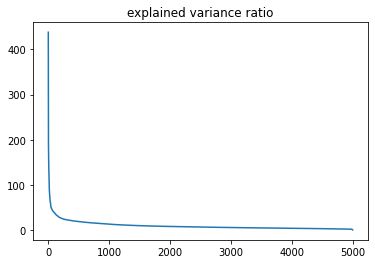

In [ ]:
# set n_components=5000 to plot this graph
#plt.plot(pipe['pca'].explained_variance_);
#plt.title('explained variance ratio');

In [ ]:
exp_test = np.load(path+'exp_gaba.npy')
exp_test = pipe.transform(exp_test)
np.save(path+'exp_test_pca', exp_test)
del exp_test

## GAN

In [4]:
exp_train = np.load(path+'exp_train_pca.npy')

In [5]:
dimension = exp_train.shape[1]

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(2048, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sigmoid function will make the range [0,1]
    model.add(layers.Dense(dimension, use_bias=True, activation='sigmoid'))

    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2048, use_bias=True, input_shape=(dimension,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1024, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1))

    return model

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              8194048   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [15]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 128])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [16]:
def train(dataset, epochs):
    delta = 0.1

    loss_hist = []
    gen_loss_hist = []
    disc_loss_hist = []
    for epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        disc_loss = 0
        for data in dataset:
            loss1, loss2 = train_step(data)
            gen_loss += loss1
            disc_loss += loss2

        print('Time for epoch {} is {} sec. Loss is {}'.format(epoch + 1, time.time()-start, gen_loss+disc_loss))
        
        loss_hist.append(gen_loss+disc_loss)
        gen_loss_hist.append(gen_loss)
        disc_loss_hist.append(disc_loss)
        if epoch > 2:
            if abs(loss_hist[-1] - loss_hist[-2]) < delta and abs(loss_hist[-2] - loss_hist[-3]) < delta:
                return loss_hist

    return loss_hist, gen_loss_hist, disc_loss_hist

In [17]:
BATCH_SIZE = 500
dataset = tf.data.Dataset.from_tensor_slices(exp_train).shuffle(1000).batch(BATCH_SIZE)

In [18]:
hist = train(dataset, 1000)

Time for epoch 1 is 1.3914282321929932 sec. Loss is 104.93605041503906
Time for epoch 2 is 0.8560903072357178 sec. Loss is 31.885852813720703
Time for epoch 3 is 0.7985336780548096 sec. Loss is 23.295860290527344
Time for epoch 4 is 0.8051862716674805 sec. Loss is 23.14215087890625
Time for epoch 5 is 0.7975397109985352 sec. Loss is 23.3486328125
Time for epoch 6 is 0.8270642757415771 sec. Loss is 29.448070526123047
Time for epoch 7 is 0.8123505115509033 sec. Loss is 57.21187210083008
Time for epoch 8 is 0.7954144477844238 sec. Loss is 25.87432289123535
Time for epoch 9 is 0.8022499084472656 sec. Loss is 64.2880859375
Time for epoch 10 is 0.7938778400421143 sec. Loss is 48.523414611816406
Time for epoch 11 is 0.8329095840454102 sec. Loss is 51.150489807128906
Time for epoch 12 is 0.7879629135131836 sec. Loss is 43.31715774536133
Time for epoch 13 is 0.800236701965332 sec. Loss is 51.8737907409668
Time for epoch 14 is 0.8018019199371338 sec. Loss is 91.28744506835938
Time for epoch 15 i

In [19]:
exp_gen = generator(tf.random.normal([1000,128]))

## Evaluation

### PCA + Visualization

In [21]:
pipe = pickle.loads(pickle.load(open(path+'pipe', 'rb')))

In [22]:
tmat = pipe['pca'].components_.transpose()

In [23]:
exp_gen = pipe.inverse_transform(exp_gen)
exp_gen = pipe['scaler1'].transform(exp_gen) @ tmat[:, :2]

In [24]:
exp_glut = pipe['scaler1'].transform(np.load(path+'exp_glut.npy')) @ tmat[:, :2]
exp_non = pipe['scaler1'].transform(np.load(path+'exp_non.npy')) @ tmat[:, :2]
exp_gaba = pipe['scaler1'].transform(np.load(path+'exp_gaba.npy')) @ tmat[:, :2]

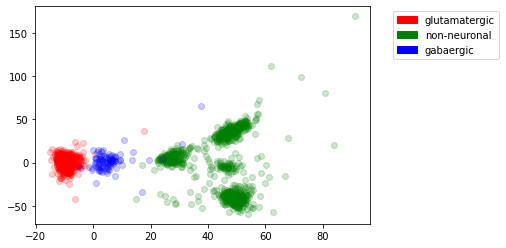

In [25]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=0.2)
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=0.2)
# blue: gabaergic
# some blue points are far away because 1st pca didn't see gaba data
x, y = list(zip(*exp_gaba[:100]))
plt.scatter(x, y, c='b', alpha=0.2)

#plt.xlim(-2, 2);
#plt.ylim(-3, 2);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
plt.legend(handles=[patch1, patch2, patch3], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

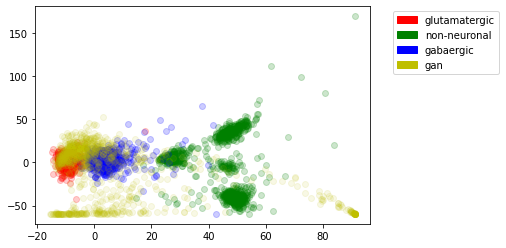

In [26]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=0.2);
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=0.2);
# blue: gabaergic
x, y = list(zip(*exp_gaba[:1000]))
plt.scatter(x, y, c='b', alpha=0.2);
# yellow: gan
x, y = list(zip(*exp_gen[:1000]))
plt.scatter(x, y, c='y', alpha=0.1);

#plt.xlim(-10, 10);
#plt.ylim(-10, 10);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()